# M2 Mathématiques Appliquées, Statistique, parcours Data Science.
## Cours Image et Intelligence Articifielle, 
## Enoncé construit par Frédéric Richard, 2021 et complété par Marine Troadec, 2021.
## TP 1.  Gradient stochastique pour la régression multinomiale.


In [1]:
# Import 
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras import models
from matplotlib.gridspec import  GridSpec

Ce TP porte sur la régression multinomiale. L'objectif est d'étudier la descente de gradient stochastique utilisée pour l'estimation des paramètres de ce modèle. On travaillera sur la classification de chiffres manuscrits à partir de la base de données MNIST.


## 1. Données MNIST

La base de données MNIST est une base de données de chiffres écrits à la main. 

![MNIST](tp1-figure0.png "MNIST")
 
Il s'agit d'une base de référence qui sert notamment à tester et comparer des algorithmes d'apprentissage statistique. L'objectif est de déterminer le chiffre écrit sur chaque image (problème de classification d'images). La base MNIST se compose 60000 images d'apprentissage et 10000 de test. En Python, elle se télécharge facilement avec le package keras:

In [2]:
from keras.datasets import mnist
(X0, Y0), (X1, Y1) = mnist.load_data()

Dans cette importation, X0 et X1 sont des bases d'images d'apprentissage et de test, respectivement. Ce sont des numpy.ndarray de taille n x 28 x 28, où n=60000 pour X0 et n=10000 pour X1. X0(i, :, :) est la ième image de la base d'apprentissage ; elle est de taille 28x28. On peut l'afficher avec la fonction imshow de matplotlib.pyplot. Les variables Y0 et Y1 contiennent les classes des observations dans chacune des bases. Les classes sont étiquetées de 0 à 9. 


Avant toute analyse, on préparer les données de la manière suivante:

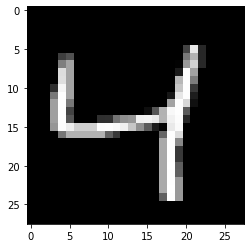

In [3]:
from matplotlib import pyplot as plt

# On met le type des images en float.
X0 = X0.astype('float32')
X1 = X1.astype('float32')
# On met les images sous la forme de vecteur.
X0 = X0.reshape(60000, 784)
X1 = X1.reshape(10000, 784) 
# On normalise les images.
X0 /= 255
X1 /= 255
n = 2
plt.imshow(X0[n, :].reshape(28, 28), cmap="gray")

## 2. Régression multinomiale.

La régression multinomiale est un modèle de classification qui étend la régression logistique lorsque le nombre de classes possibles est supérieur à 2. Le modèle est le suivant. On décrit la classe d'un individu au moyen d'une variable aléatoire $Y$ à valeurs dans un ensemble discret $\{1,\cdots, K\}$ représentant des étiquettes de classe. Pour chaque individu, on dispose de variables $x$ (dites de régression) dans $\mathbb{R}^p$. On suppose que la distribution de probabilités de $Y$ dépend de $x$ et d'un ensemble $\theta = (\theta^{(k)})_{k=1}^K$ de $K$ vecteurs de paramètres inconnus $\theta^{(k)}$ dans $\mathbb{R}^{p+1}$ selon le modèle **"soft-max"**
\begin{equation} \label{eqn:softmax_proba}
  \forall \: k \in \{1,\cdots, K\}, \: \mathbb{P}(Y = k) = \frac{\exp(\langle \theta^{(k)}, \:  \tilde{x} \rangle )}{\sum_{m=1}^K \exp(\langle \theta^{(m)},  \: \tilde{x} \rangle )},\:\:\mathrm{avec}\:\: \tilde{x} =  \left( \begin{array}{c} 1 \\ x \end{array} \right). \end{equation}

Les estimateurs du maximum de vraisemblance de l'échantillon sont les paramètres $\theta$ qui minimisent le **critère d'entropie croisée**:
    \begin{equation} \label{eqn:entropiecroisee}
       \mathcal{S}(\theta) = - \frac{1}{n} \sum_{i=1}^n \sum_{k=1}^K z_i^{(k)} \log\left(p_i^{(k)}(\theta) \right),\end{equation}
    avec
    \begin{equation} 
    z_i^{(k)} =  \mathbf{1}_{y_i = k}\:\:\:\mathrm{et}\:\:\: p_i^{(k)}(\theta) = \frac{\exp(\langle \theta^{(k)},  \: \tilde{x}_i \rangle )}{\sum_{m=1}^K \exp(\langle \theta^{(m)},  \: \tilde{x}_i \rangle )}. 
    \end{equation}   

 

Dans le cadre de ce TP, l'objectif est de classer les images MNIST en K=10 classes $\{0, \cdots, 9\}$. La variable $x_i$ représente la ième image (sous forme vectorielle) de la base d'apprentissage et $y_i$ son étiquette de classe.


## 3. Descente de gradient.

Une descente de gradient est un algorithme itératif permettant de minimiser une application différentiable $\mathcal{S}$ par rapport à un ensemble de variables $\theta$. Dans la descente de gradient à pas fixe, la mise à jour des variables $\theta$ s'écrit à chaque itération
\begin{equation} \label{eqn:miseajour}
  \theta \longleftarrow \theta - \rho \: \nabla_{\theta}  \mathcal{S}(\theta),
  \end{equation}
o\`u $\rho>0$ désigne un pas fixe et $\nabla_{\theta} \mathcal{S}$ le gradient de $\mathcal{S}$ par rapport à $\theta$. 


\exo  Le gradient de l'entropie croisée $\mathcal{S}$ par rapport à $\theta^{(k)}$ en $\theta$ vaut
    $$ \nabla_{\theta^{(k)}} \mathcal{S}(\theta) = \frac{1}{n} \sum_{i=1}^{n} \left(p_i^{(k)}(\theta) - z_i^{(k)}\right) \tilde{x}_i . $$


**Exercice 1.** Écrire une fonction Python qui calcule ce gradient en respectant le modèle suivant.

In [4]:
def Soft_Max(X, Theta):
    """
    Modèle soft-max de distribution de probabilité.        

    Parameters
    ----------
    X : ndarray (n x p).
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation. 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe.
        La colonne k contient les paramètres de régression 
        pour la classe k.

    Returns
    -------
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités
        des classes de toutes les observations.
        Sur la ligne i et la colonne k, P[i, k] donne l'estimation de 
        la probabilité que la ième observation soit dans la classe k
        selon le modèle soft-max.
    """   
    # Transformations linéaires et exponentielles.
    P = np.exp(np.dot(X, Theta[1:, :]) + Theta[0, :])
    # Normalisation.
    P = P / np.sum(P, axis=1).reshape(P.shape[0], 1)

    return(P)

def Cross_Entropy(C, P):
    """
    Critère d'entropie croisée.

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités des classes de toutes les observations
        (voir Soft_Max).
   
    Returns
    -------
    J : scalar.
        Valeur de l'entropie croisée.
    """ 
    V = np.zeros(C.shape)
    for i in range(V.shape[0]):
        V[i] = np.log(P[i, C[i]])
    
    return(-np.mean(V, axis=None))

In [5]:
def Gradient(C,P,X, Theta):
    """
    Gradient de l'entropie croisée 
    
    Paramètres 
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités des classes de toutes les observations
        (voir Soft_Max).
    X : ndarray (n x p).
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation. 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe.
        La colonne k contient les paramètres de régression 
        pour la classe k.
    
    Returns
    -------
    G : ndarray (p+1 x K). 
    """
    X = np.c_[np.ones(X.shape[0]),X]  #Ajoute le vecteur 1 à la matrice de desing 
    n = X.shape[0] 
    G = np.zeros(Theta.shape)  #Matrice contenant après les gradients des différents paramètres 
    
    for k in range(P.shape[1]) :  #Pour chaque paramètre associé à une classe    
        z = [0 if np.where(P[i] == P[i,:].max())[0][0] != C[i] and C[i] != k else 1 for i in range(n)]  #Vecteur indicateur 
        G[:,k] = np.sum(1/n*(X.T*(P[:,k]-z)), axis=1)  #Gradient de tous les paramètres de cette classe 
    return G 

In [6]:
# Variation du code pour tester l'efficacité. N'est pas plus rapide et meme plus long que l'autre version.

#def Gradient(C,P,X, Theta):
   
#    X = np.c_[np.ones(X.shape[0]),X]  #Ajoute le vecteur 1 à la matrice de desing 
#    n = X.shape[0] 
#    G = np.zeros(Theta.shape)  #Matrice contenant après les gradients des différents paramètres 
#    z = np.array([[0 if np.where(P[i] == P[i,:].max())[0][0] != C[i] and C[i] != k else 1 for i in range(n)] for k in range(P.shape[1])])
    
#    for k in range(P.shape[1]) : 
        
#        G[:,k] = np.sum(1/n*(X.T*(P[:,k]-z[k,:].T)), axis = 1) 
    
#    return G 

**Exercice 2.** Appliquer l'algorithme de descente de gradient sur les données MNIST en prenant 50000 données d'apprentissage et 10000 de validation. A chaque époque (itération), calculer la valeur de l'entropie sur les données d'apprentissage et de validations, ainsi que les scores de classification sur ces deux jeux de données. Relever également le temps d'exécution de chaque époque. Tracer ensuite les valeurs d'entropie et les scores de classification en fonction du temps de calcul (et/ou de l'époque). Pour le calcul du score de classification, on pourra s'aider de la fonction suivante.

In [7]:
def Classification_Score(C, X, Theta):
    """
    Score de classification obtenu par régression multinomiale.

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    P = Soft_Max(X, Theta)
    Cest = np.argmax(P, axis=1)
    score = np.nonzero(Cest == C)[0].size / P.shape[0] * 100
    
    return(score, P)

In [8]:
#Création de données de validation 

#X_train = X0[:50000]
#X_test = X0[50000:]

#y_train = Y0[:50000]
#y_test = Y0[50000:]

#Jeu de données train et test

X_train = X0
X_test = X1

y_train = Y0
y_test = Y1

#iteration = 800

iteration = 150

In [9]:
random.seed(10)
Theta = np.random.rand(X0.shape[1]+1, 10)

In [10]:
def DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration, rho=1e-1) :
    
    """
    Algorithme de descente de gradient 

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Y : ndarray (n x 1)
        Vecteur contenant les classes de chaque exemple 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.
    Iteration : réel 
        Nombre de fois où le modèle est entrainé sur le jeu de données 
    rho : nombre décimal 
        pas fixe 

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    
    Entropie_Train = [] #liste qui contiendra le loss
    score_train = []  
    
    Entropie_Test = []
    score_test = []
    
    Theta = Theta.astype('float64')
    
    for i in range(iteration) : 
        
        start_time = time.time()
        
        P_train =  Soft_Max(X_train, Theta)  #Proba de chaque classe pour le train 
        P_test = Soft_Max(X_test, Theta)
        
        Entropie_Train.append(Cross_Entropy(y_train,P_train))  #Erreur train
        Entropie_Test.append(Cross_Entropy(y_test, P_test))  #Erreur test 
        
        score_train.append(Classification_Score(y_train, X_train, Theta)[0])  #Score train 
        score_test.append(Classification_Score(y_test, X_test, Theta)[0])  #Score test
    
        G = Gradient(y_train,P_train,X_train, Theta)
        
        Theta -= rho*G  #Mise à jour du gradient 
        
        print("--- %s seconds ---" % (time.time() - start_time))
        
    return(Entropie_Train,Entropie_Test,score_train,score_test, Theta)
        
        

In [11]:
(Entropie_Train,Entropie_Test,score_train,score_test, Theta_DG) = DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration)

--- 9.38464879989624 seconds ---
--- 10.391215085983276 seconds ---
--- 9.254638195037842 seconds ---
--- 8.691478967666626 seconds ---
--- 8.883113861083984 seconds ---
--- 8.805779933929443 seconds ---
--- 8.945041179656982 seconds ---
--- 9.032530069351196 seconds ---
--- 8.72620701789856 seconds ---
--- 8.823044776916504 seconds ---
--- 8.537524938583374 seconds ---
--- 8.579976797103882 seconds ---
--- 8.740776062011719 seconds ---
--- 8.688063859939575 seconds ---
--- 9.050540208816528 seconds ---
--- 8.681586980819702 seconds ---
--- 8.908906936645508 seconds ---
--- 8.713773250579834 seconds ---
--- 8.485625982284546 seconds ---
--- 8.660274982452393 seconds ---
--- 8.774489164352417 seconds ---
--- 8.571286678314209 seconds ---
--- 8.50779414176941 seconds ---
--- 8.452661991119385 seconds ---
--- 8.359086275100708 seconds ---
--- 8.266335010528564 seconds ---
--- 8.409608125686646 seconds ---
--- 8.39441728591919 seconds ---
--- 8.420417070388794 seconds ---
--- 8.31786704063

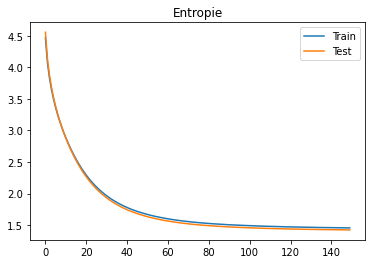

In [12]:
x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.show()

Les deux courbes décroissent à la même vitesse, ce qui est un marqueur d'un bon fonctionnement de l'agorithme. En effet, nous observons ni over ou under fitting. 

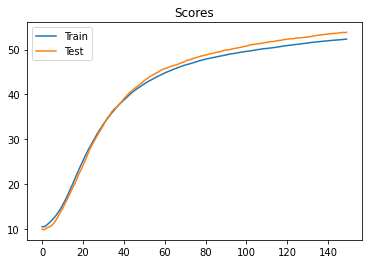

In [13]:
x = np.array([i for i in range(iteration)])
y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.show()

---
Les scores plafonnent à 55, ce qui n'est pas incoryable .. La régression logistique appliquée comme ici ne prend pas en compte l'emplacement des informations de l'image. Cette dernière est traitée comme un ensemble lisse de données, or l'emplacement des informaitons est importante ! Nous pourions regarder plus précisément ce que notre modèle prédit pour essayer de comprendre ce qui est appris.

---

**Fonction de prédition**

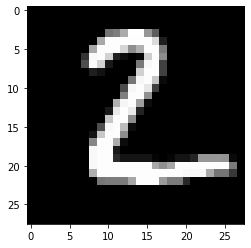

In [14]:
plt.imshow(X_test[1, :].reshape(28, 28), cmap="gray")

In [15]:
def prediction(X, Theta) : 
    P = Soft_Max(X, Theta)
    #print(P[0])
    pred = []
    for i in P : 
        pred.append(np.argmax(i))
    return pred

In [16]:
y_pred = prediction(X_test, Theta_DG)

In [17]:
y_pred[1]

2

## 4. Descente de gradient stochastique par mini-lots.

L'algorithme de gradient stochastique est une modification de l'algorithme du gradient qui consiste à prendre un seul exemple d'apprentissage au hasard pour mettre à jour le paramètre $\theta$ à chaque époque. On s'intéresse ici à une variante de l'algorithme de gradient stochastique qui fait ces mises à jour en prenant une série de mini-lots (batchs) d'exemples d'apprentissage tiré au hasard. Pour cet algorithme, le gradient de l'entropie croisée $\mathcal{S}$ s'écrira
$$ \nabla_{\theta^{(k)}} \mathcal{S}(\theta) = \frac{1}{m} \sum_{i \in B_j} \left(p_i^{(k)}(\theta) - z_i^{(k)}\right) \tilde{x}_i, $$
o\`u $B_j$ est un ensemble qui regroupe $m$ indices d'un jème lot d'observations pris au hasard. Une époque de l'algorithme consistera en une série de plusieurs mises à jour faisant intervenir différents lots. Le nombre de mises à jour pour une époque pourra par exemple être fixé à $\lfloor n / m \rfloor$. La descente de gradient ordinaire est un cas particulier de la descente de gradient stochastique lorsque l'on fixe $m=n$. 

**Exercice 3.** Modifier le programme de la section précédente pour inclure des mises à jour sur mini-lots. Appliquer le programme aux données MNIST. Comparer les convergences des algorithmes de gradient et gradient stochastique par mini-lots. Discuter.



In [18]:
def DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=1,rho=1e-1) :
    
    """
    Algorithme de descente de gradient 

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Y : ndarray (n x 1)
        Vecteur contenant les classes de chaque exemple 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.
    Iteration : réel 
        Nombre de fois où le modèle est entrainé sur le jeu de données 
    rho : nombre décimal 
        pas fixe 
    batch : réel 
        Nombre de mini-lots

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    
    Entropie_Train = []
    score_train = []
    
    Entropie_Test = []
    score_test = []
    
    Theta = Theta.astype('float64')
    
    pas = X_train.shape[0] // batch  #Division en mini lot 
    
    for i in range(iteration) :  #Pour chaque itération 
        
        ind = 0
        
        for b in range(batch) :  #Pour chaque mini-lot 
        
            start_time = time.time()

            P_train =  Soft_Max(X_train[ind:ind+pas], Theta)          

            G = Gradient(y_train[ind:ind+pas],P_train,X_train[ind:ind+pas], Theta)

            Theta -= rho*G
            
            ind += pas 
            
            print("--- %s seconds ---" % (time.time() - start_time))
            
        P_train =  Soft_Max(X_train, Theta)
        P_test = Soft_Max(X_test, Theta)
        
        Entropie_Train.append(Cross_Entropy(y_train,P_train))
        Entropie_Test.append(Cross_Entropy(y_test, P_test))
        
        score_train.append(Classification_Score(y_train, X_train, Theta)[0])
        score_test.append(Classification_Score(y_test, X_test, Theta)[0])
        
    return(Entropie_Train,Entropie_Test,score_train,score_test)

In [19]:
random.seed(10)
Theta = np.random.rand(X0.shape[1]+1, 10)
iteration = 15 #Plus bas car trop long pour cette version du code 

In [20]:
(Entropie_Train,Entropie_Test,score_train,score_test) = DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=10)

--- 0.6600949764251709 seconds ---
--- 0.6688051223754883 seconds ---
--- 0.6765000820159912 seconds ---
--- 0.6630580425262451 seconds ---
--- 0.6502211093902588 seconds ---
--- 0.6890840530395508 seconds ---
--- 0.6667129993438721 seconds ---
--- 0.652454137802124 seconds ---
--- 0.6468009948730469 seconds ---
--- 0.6643881797790527 seconds ---
--- 0.6544229984283447 seconds ---
--- 0.6798028945922852 seconds ---
--- 0.6608138084411621 seconds ---
--- 0.6507580280303955 seconds ---
--- 0.6539590358734131 seconds ---
--- 0.6528329849243164 seconds ---
--- 0.669806957244873 seconds ---
--- 0.6416058540344238 seconds ---
--- 0.6515669822692871 seconds ---
--- 0.6371550559997559 seconds ---
--- 0.6282339096069336 seconds ---
--- 0.6532750129699707 seconds ---
--- 0.663830041885376 seconds ---
--- 0.6417911052703857 seconds ---
--- 0.6313588619232178 seconds ---
--- 0.6473052501678467 seconds ---
--- 0.6380782127380371 seconds ---
--- 0.6436507701873779 seconds ---
--- 0.641463041305542 s

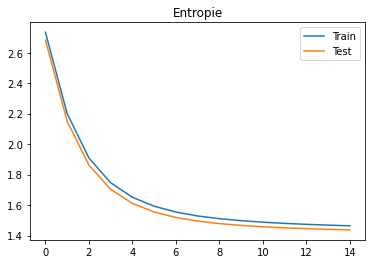

In [21]:
x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.show()

---
Ce graphique nous montre ni under ni over fitting. 

---

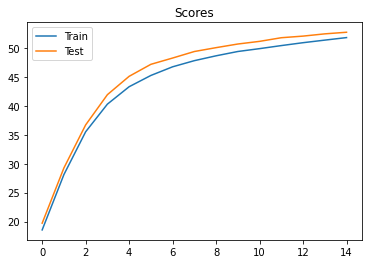

In [22]:
x = np.array([i for i in range(iteration)])
y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.show()

---
Le score atteint 55% de réussite avec 15 fois moins d'itérations que pour le gradient non stochastique.

Lorsque rho est fixé à 1e-2, le nombre d'itération devait être à 100 pour atteindre 50 de score. Nous pouvons aussi voir un début de gap entre le test et le train dont il faut être attentif car il peut souligner un début d'overfitting.

---

**Exercice 4.** On réduit le nombre d'exemples d'apprentissage à 1000. Comparer et discuter les convergences des algorithmes appliqués dans ce cas et dans celui o\`u le nombre d'exemple est fixé à 50000.



In [23]:
X_train = X0[:1000]
y_train = Y0[:1000]

In [24]:
#random.seed(10)
#Theta = np.random.rand(X_train.shape[1]+1, 10)

In [25]:
(Entropie_Train,Entropie_Test,score_train,score_test, Theta_DG) = DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration)
(Entropie_Train_St,Entropie_Test_St,score_train_St,score_test_St) = DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=10)

--- 0.1808609962463379 seconds ---
--- 0.17665910720825195 seconds ---
--- 0.17472004890441895 seconds ---
--- 0.16695809364318848 seconds ---
--- 0.1672508716583252 seconds ---
--- 0.1604011058807373 seconds ---
--- 0.16713690757751465 seconds ---
--- 0.16806316375732422 seconds ---
--- 0.16853594779968262 seconds ---
--- 0.16606521606445312 seconds ---
--- 0.16706490516662598 seconds ---
--- 0.16236495971679688 seconds ---
--- 0.1731562614440918 seconds ---
--- 0.15606307983398438 seconds ---
--- 0.16271114349365234 seconds ---
--- 0.05779600143432617 seconds ---
--- 0.010014057159423828 seconds ---
--- 0.00979304313659668 seconds ---
--- 0.009992837905883789 seconds ---
--- 0.00975179672241211 seconds ---
--- 0.00981903076171875 seconds ---
--- 0.009767770767211914 seconds ---
--- 0.010339975357055664 seconds ---
--- 0.010777950286865234 seconds ---
--- 0.010522127151489258 seconds ---
--- 0.011094808578491211 seconds ---
--- 0.014406919479370117 seconds ---
--- 0.012143850326538086

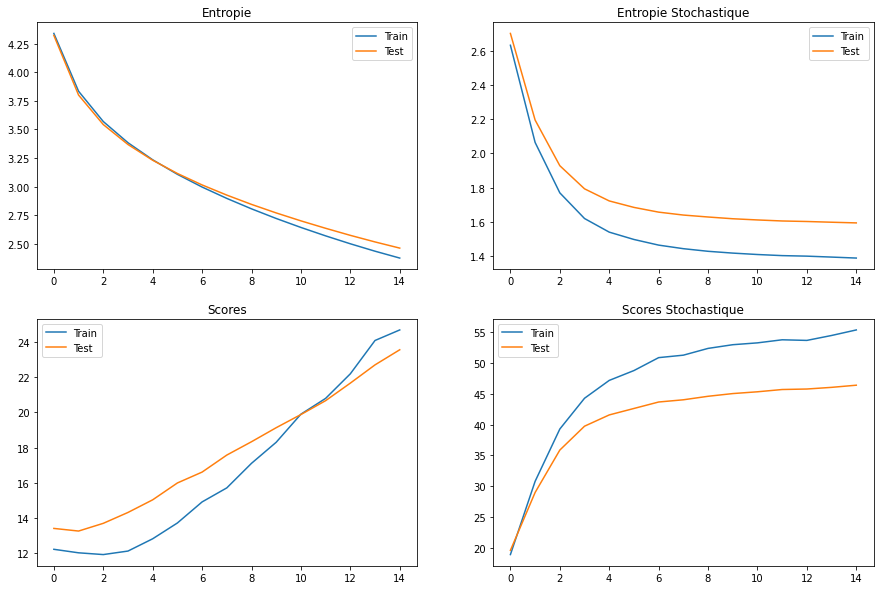

In [26]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.subplot(222)

y = np.array(Entropie_Train_St)
w = np.array(Entropie_Test_St)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie Stochastique")

plt.subplot(223)

y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.subplot(224)

y = np.array(score_train_St)
w = np.array(score_test_St)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores Stochastique")



plt.show()


---
On peut observer que la fonction de perte diminue plus rapidement dans le cas d'un gradient stochastique (mini-batch) avec peu de données. Le score atteint avec le gradient stochastique est bien meilleur que le gradient classique. Néanmomins ces courbes montrent clairement un overfitting du au nombre trop restreint de données. 

Afin d'avoir de meilleurs résultats il serait interessant d'integrer un terme de régularisation au gradient ou de bruité les données. 

---

## 6. Régression multinomiale en keras.

**Exercice 5.** Mettre en oeuvre en keras le modèle de régression multinomiale. L'appliquer aux données MNIST. Tracer et commenter l'historique de l'apprentissage.


In [27]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
num_classes = 10
input_shape = (784,1)

In [29]:
y_train = keras.utils.to_categorical(Y0, num_classes) #Le vecteur labels est transformé en matrice (n x k) 
#où y_nk = 1 quand y_n = k, 0 sinon 
y_test = keras.utils.to_categorical(Y1, num_classes)

In [30]:
y_train.shape

(60000, 10)

In [31]:
model = keras.Sequential(
    [
        keras.Input(shape=(784,1)), #shape de chaque vecteur d'entrée 
        layers.Flatten(), # Applatissement de la matrice (784 x 10) 
        layers.Dense(num_classes, activation="softmax"), #Couche dense applicant la fonction d'acitivation softmax
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"]) #  Fonction de perte cossentropy et score 


In [33]:
iteration = 20

In [34]:
history = model.fit(X0, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 2s 878us/step - loss: 0.4732 - accuracy: 0.8752 - val_loss: 0.3032 - val_accuracy: 0.9163
Epoch 2/20
1500/1500 [==============================] - 1s 785us/step - loss: 0.3127 - accuracy: 0.9119 - val_loss: 0.2872 - val_accuracy: 0.9208
Epoch 3/20
1500/1500 [==============================] - 1s 756us/step - loss: 0.2966 - accuracy: 0.9180 - val_loss: 0.2779 - val_accuracy: 0.9242
Epoch 4/20
1500/1500 [==============================] - 1s 753us/step - loss: 0.2900 - accuracy: 0.9209 - val_loss: 0.2762 - val_accuracy: 0.9262
Epoch 5/20
1500/1500 [==============================] - 1s 762us/step - loss: 0.2856 - accuracy: 0.9223 - val_loss: 0.2742 - val_accuracy: 0.9274
Epoch 6/20
1500/1500 [==============================] - 1s 783us/step - loss: 0.2831 - accuracy: 0.9243 - val_loss: 0.2752 - val_accuracy: 0.9267
Epoch 7/20
1500/1500 [==============================] - 1s 755us/step - loss: 0.2820 - accuracy: 0.9253 - val_loss: 0.2779 -

In [35]:
score = model.evaluate(X1, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.31680506467819214
Test accuracy: 0.9247000217437744


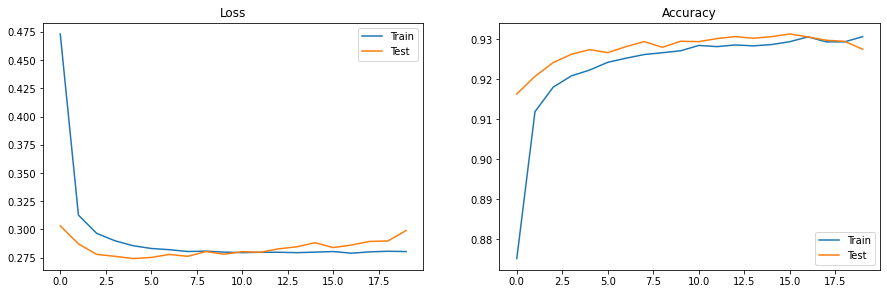

In [36]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Ici on observe un bon entrainement sur les données. Le classifieur est entrainé sur 6000 données où 1200 servent de cross validation. Il est tout de même testé à chaque tour sur 1000 données séparées. 

La fonction de perte commence à augmenter à partir de 10 epochs, cela nous renseigne sur le moment où nous aurions pu arrêter l'entrainement. 

Nous pouvons aussi se rendre compte que Keras est bien mieux optimisé que notre premier code, le temps de traitement est significativement plus court. 

---

**Exercice 6.** Mettre en oeuvre en Keras le réseau de neurones convolutionnel inspiré de LeNet-5 dont les couches sont décrites dans le tableau ci-dessous:

| Type | Cartes | Noyau | Pas | Activation |
|------|--------|-------|-----|-------|
| Conv.| 6      | 5x5   | 1   | tanh  |
| Av. Pooling | 6 | 2x2 | 2 | - | 
|Conv. | 12 | 5x5 | 1 | tanh |
| Av. Pooling | 12 | 2x2 | 4 | - | 
| Dense | - | 10 | - | softmax|

1. Indiquer la dimension des images et le nombre de paramètres à chaque couche. Comparer avec le modèle dense de la régression multinomiale.

2. Appliquer le modèle aux données MNIST. Comparer les résultats avec ceux de la régression multinomiale.

3. Visualiser les noyaux de convolution et apporter quelques éléments d'interprétation.

4. Faire l'apprentissage du réseau sur 6000 exemples. Comparer ses performances avec le réseau dense appris dans les mêmes conditions. Discuter.



### Vecteur

In [37]:
keras.backend.clear_session()

In [38]:
x_train = np.expand_dims(X0, -1)
x_test = np.expand_dims(X1, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 784, 1)
60000 train samples
10000 test samples


In [39]:
iteration = 20
input_shape = (784, 1)
num_classes = 10

In [40]:
y_train = keras.utils.to_categorical(Y0, num_classes)
y_test = keras.utils.to_categorical(Y1, num_classes)

In [41]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        keras.layers.Conv1D(filters=6, kernel_size=5, strides=1, activation="tanh"),
        keras.layers.AveragePooling1D(2*2, strides=2),
        keras.layers.Conv1D(filters=12, kernel_size=5, strides=1, activation="tanh"),
        keras.layers.AveragePooling1D(2*2, strides=4),
        keras.layers.Flatten(),
        keras.layers.Dense(units=num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 780, 6)            36        
                                                                 
 average_pooling1d (AverageP  (None, 389, 6)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 385, 12)           372       
                                                                 
 average_pooling1d_1 (Averag  (None, 96, 12)           0         
 ePooling1D)                                                     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 10)                1

In [42]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3963 - accuracy: 0.8871 - val_loss: 0.2457 - val_accuracy: 0.9278
Epoch 2/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2403 - accuracy: 0.9265 - val_loss: 0.2154 - val_accuracy: 0.9358
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1986 - accuracy: 0.9397 - val_loss: 0.1722 - val_accuracy: 0.9498
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1747 - accuracy: 0.9473 - val_loss: 0.1690 - val_accuracy: 0.9512
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1598 - accuracy: 0.9515 - val_loss: 0.1632 - val_accuracy: 0.9525
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1500 - accuracy: 0.9544 - val_loss: 0.1496 - val_accuracy: 0.9576
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1411 - accuracy: 0.9580 - val_loss: 0.1528 - val_accurac

In [43]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1090637594461441
Test accuracy: 0.96670001745224


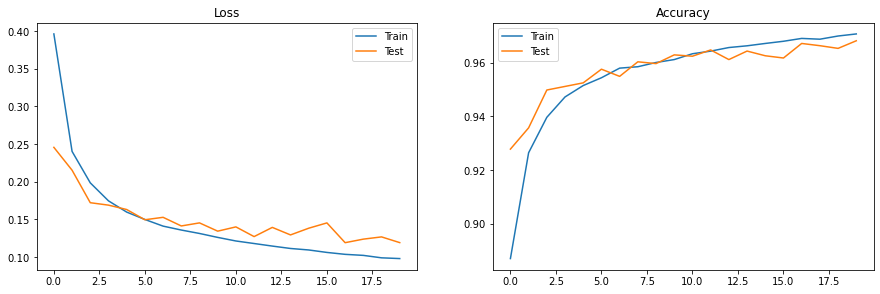

In [44]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Ici le modèle en 1D est assez efficace mais les courbes varient ce qui évoque une instabilité de l'apprentissage. En effet, les images étant en 2D, l'apprentissage en 1D n'est pas naturelle. L'information spatiale est perdue. 

---

### Matrice

In [45]:
keras.backend.clear_session()

In [46]:
X0 = X0.reshape(60000, 28, 28)
X1 = X1.reshape(10000, 28, 28)
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(X0, -1)
x_test = np.expand_dims(X1, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [47]:
iteration = 20
num_classes = 10

In [48]:
y_train = keras.utils.to_categorical(Y0, num_classes)
y_test = keras.utils.to_categorical(Y1, num_classes)

In [49]:
input_shape = (28, 28,1)
num_classes = 10

In [50]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(2*2, strides=2),
        keras.layers.Conv2D(filters=12, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 11, 11, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 12)          1812      
                                                                 
 average_pooling2d_1 (Averag  (None, 3, 3, 12)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 108)               0         
                                                                 
 dense (Dense)               (None, 10)                1

In [51]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5054 - accuracy: 0.8586 - val_loss: 0.2382 - val_accuracy: 0.9322
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1987 - accuracy: 0.9426 - val_loss: 0.1407 - val_accuracy: 0.9593
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1311 - accuracy: 0.9614 - val_loss: 0.1060 - val_accuracy: 0.9693
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1022 - accuracy: 0.9706 - val_loss: 0.0878 - val_accuracy: 0.9745
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0870 - accuracy: 0.9743 - val_loss: 0.0788 - val_accuracy: 0.9769
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.0707 - val_accuracy: 0.9797
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0696 - accuracy: 0.9787 - val_loss: 0.0718 - val_accuracy:

In [52]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04206538200378418
Test accuracy: 0.9861000180244446


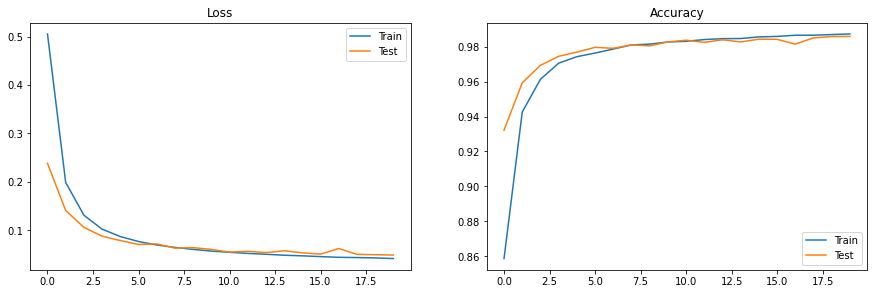

In [53]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Nous pouvons observer que les résultats du mdèles en 2D est meilleur qu'en une seule dimension, en effet, l'information spatiale est conservée. Nous puvons aussi voir que l'entrainement pourrait s'arreter au bout de 5 epochs ce qui est très rapide. 

---

### Visualisation des couches 

In [54]:
keras.backend.clear_session()

In [55]:
model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation="tanh"))
model.add(keras.layers.AveragePooling2D(2*2, strides=2))
model.add(keras.layers.Conv2D(filters=12, kernel_size=(5, 5), strides=1, activation="tanh"))
model.add(keras.layers.AveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(num_classes, activation="softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 11, 11, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 12)          1812      
                                                                 
 average_pooling2d_1 (Averag  (None, 3, 3, 12)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 108)               0         
                                                                 
 dense (Dense)               (None, 10)                1

In [56]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5185 - accuracy: 0.8571 - val_loss: 0.2173 - val_accuracy: 0.9370
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1727 - accuracy: 0.9500 - val_loss: 0.1334 - val_accuracy: 0.9633
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1149 - accuracy: 0.9663 - val_loss: 0.0964 - val_accuracy: 0.9726
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0932 - accuracy: 0.9720 - val_loss: 0.0859 - val_accuracy: 0.9746
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0811 - accuracy: 0.9756 - val_loss: 0.0756 - val_accuracy: 0.9786
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0725 - accuracy: 0.9778 - val_loss: 0.0697 - val_accuracy: 0.9791
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0666 - accuracy: 0.9794 - val_loss: 0.0671 - val_accuracy:

In [57]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03871733695268631
Test accuracy: 0.9878000020980835


In [58]:
img_tensor = X1[1].reshape(28, 28)
print(img_tensor.shape)
img_tensor = image.img_to_array(img_tensor)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
#plt.imshow(img_tensor)
#plt.show()
print(img_tensor.shape)

(28, 28)
(28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


In [59]:
layer_outputs = [layer.output for layer in model.layers[:7]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input

In [60]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

**Image d'entrée**

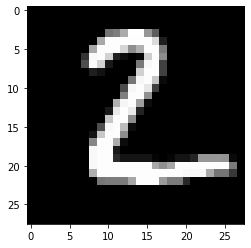

In [61]:
plt.imshow(X1[1, :].reshape(28, 28), cmap="gray")
plt.show()

**1ere couche de convolution** 

In [62]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 24, 24, 6)


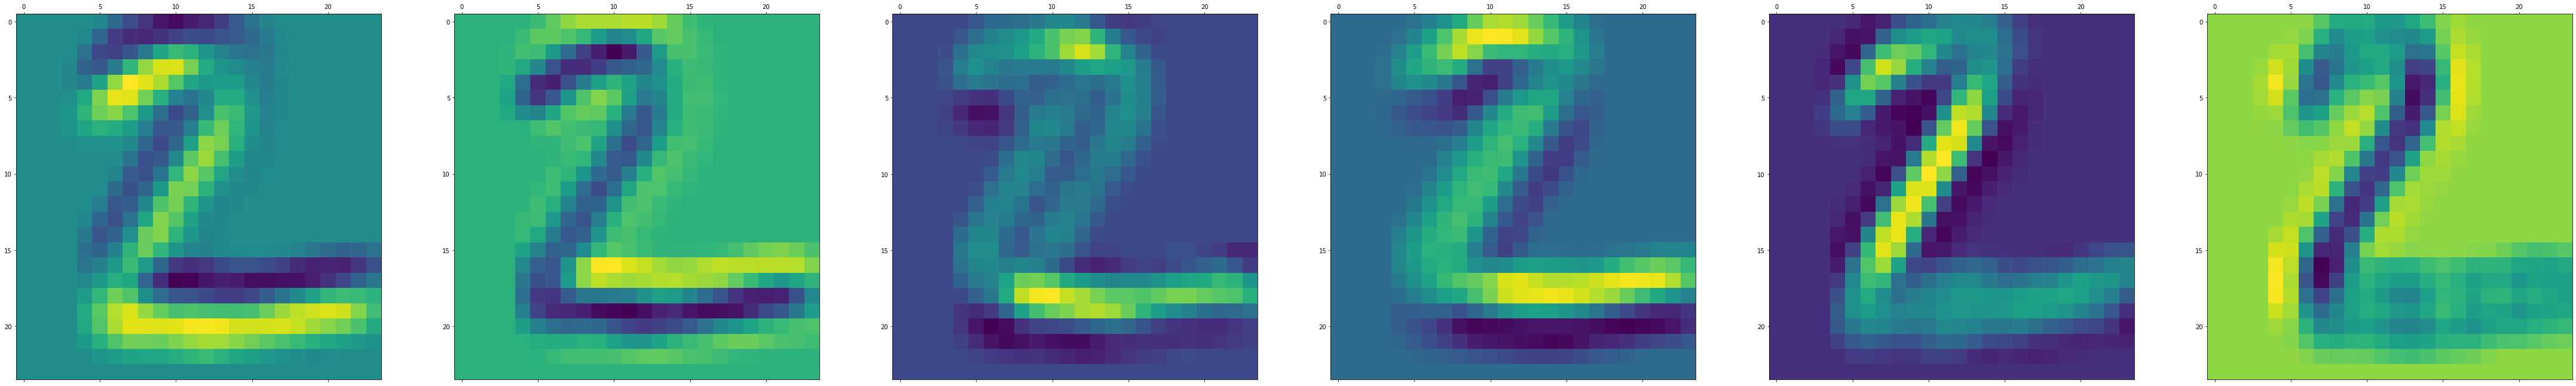

In [63]:
ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
Ici nous pouvons observer le filtrage oppéré sur les images à la première couche de convltion. Certaines images recrééent soulignent l'importance apportée à la direction des trais (1,2,6 ièmes images) ou le contraste (5ième image). 

---

**2eme couche**

In [64]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 11, 11, 6)


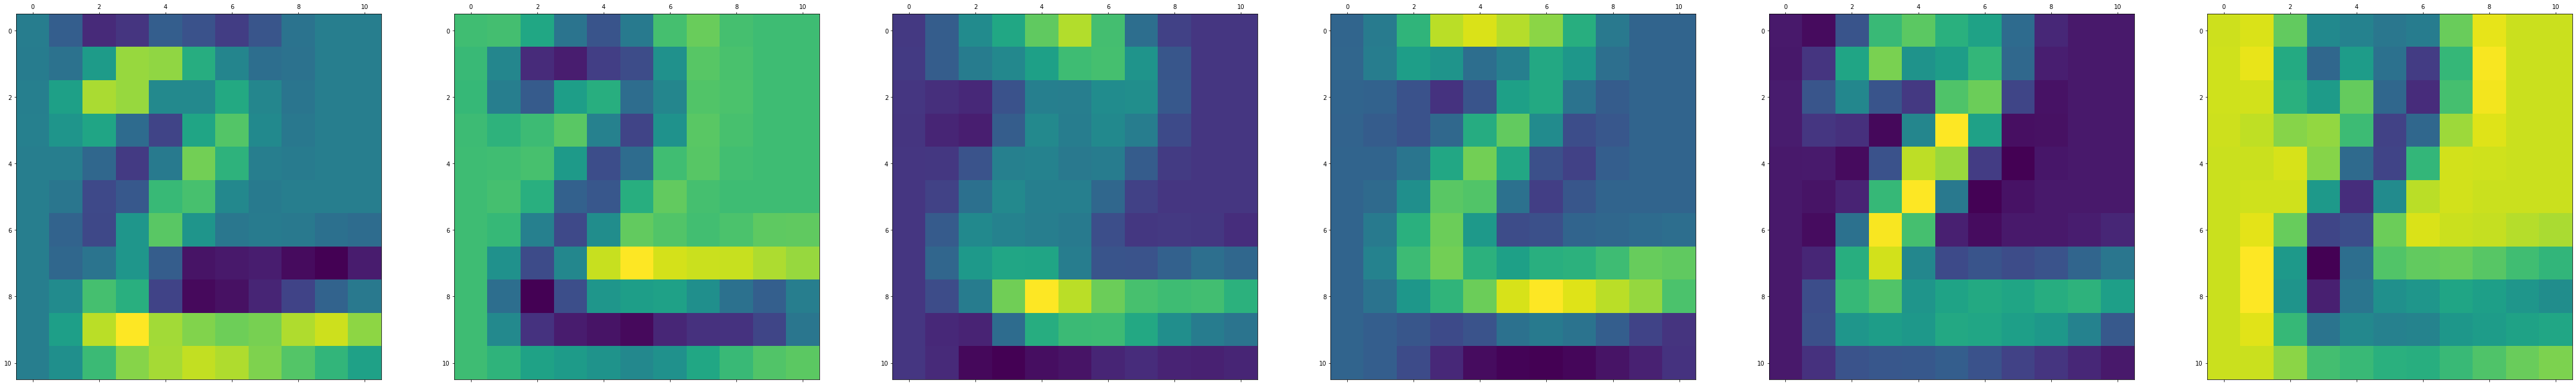

In [65]:
ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
La seconde couche correspond à la réduction de l'image par moyenne. Ainsi les mêmes informations que la première couche sont représentés mais en condensées.

---

**3eme couche**

In [66]:
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(1, 7, 7, 12)


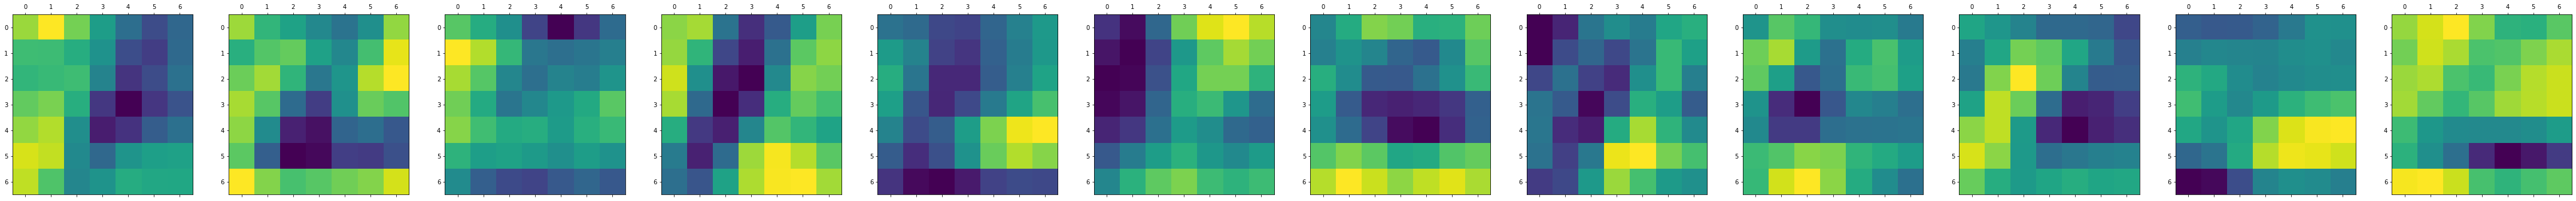

In [67]:
ncols = 12
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
Cette seconde couche de convolution est plus abstraite et il est difficile d'en donner une interprétation. 

---

**4eme couche**

In [68]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 3, 3, 12)


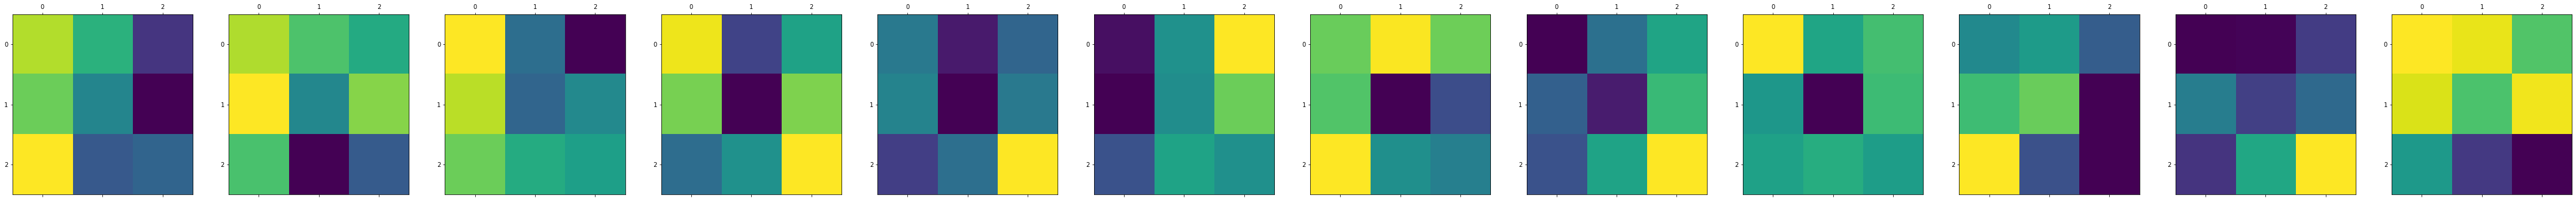

In [69]:
ncols = 12
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
Nous avons ainsi pu voir les images reconstituées à chaque couche et ainsi voir ce qui permet au modèle de reconaitre les chiffres. Pour mieux comprendre il faudrait comparer ces différentes couches avec différents chiffres. 

---

Il existe un site internet permetant de visualiser un réseau de neurone entrainé sur les données MNIST, voici le lien : https://www.cs.ryerson.ca/~aharley/vis/conv/